In [37]:
### THIS CELL IS JUST FOR 3RD PARTY FUNCTIONS ### 
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
        ## carry over code placed here to reduce clutter


# i did make this tho
def stft( input_sound, dft_size, hop_size, zero_pad, window=1.0):
    length = len(input_sound)
    
    # Part1. splitting into frames
    FrameAmount = math.ceil((length) / hop_size) + 1
    slices = np.arange(dft_size * FrameAmount).reshape(dft_size, FrameAmount)
    # set slices into array
    for i in range(FrameAmount):
        start = i * hop_size
        end = start + dft_size
        
        data = input_sound[start:end]
        
        # input too short... need to zero padd end
        if(data.shape[0] < dft_size):
            zero_padd = np.zeros(dft_size - data.shape[0])
            data = np.hstack((data, zero_padd))
           
        slices[:,i] = data * window
        
    #  Part2. Do fft of input slices        
    size = dft_size+zero_pad   
    if(size%2 ==0):
        NumBins = ((size) // 2) + 1
    else:
        NumBins = ((size) + 1) // 2
    
    NumBins = int(NumBins)
    f = np.arange(NumBins * FrameAmount, dtype=np.complex_).reshape(NumBins, FrameAmount)   
    f[:,:] = 0. + 0.j
    
    for i in range(FrameAmount):
        f[:,i] = np.fft.rfft(slices[:,i], size)      

    # Return a complex-valued spectrogram (frequencies x time)
    return f

def FormatAxis(specArray, sr, time):
    length = specArray.shape[1]
    numbins = specArray.shape[0]
    timeline = np.linspace(0, time, length)
    freqline = np.linspace(0, sr/2, numbins)
    #freqline = np.fft.fftfreq(numbins, d=1./sr)
    return timeline, freqline


def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

Waiting for transcription to complete...
Transcription complete...


old sound


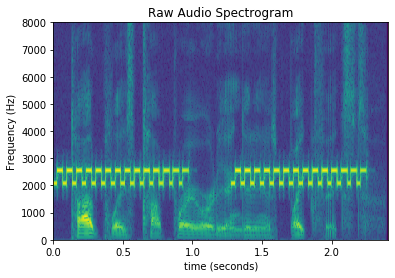

new sound


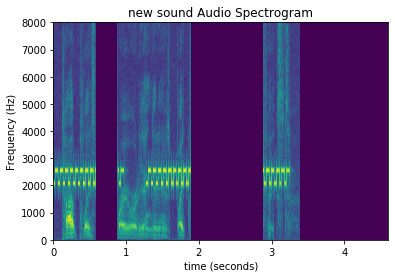

new sound (using individual overlap function)


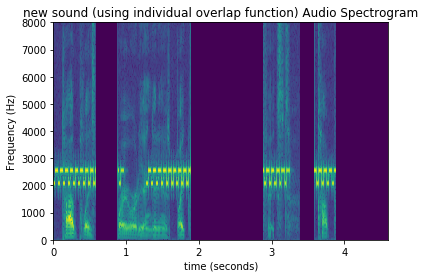

new sound (using individual break function)


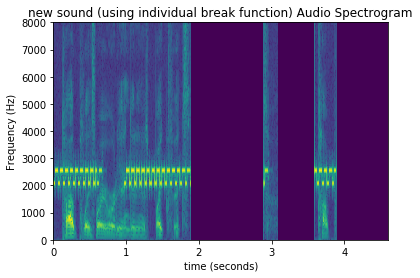

In [70]:
## REAL POC CELL ##

"""
Created on Mon Feb 10 16:36:55 2020
No stealy 
@author: ecouv
"""

from google.cloud import speech_v1
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import speech_recognition as sr
import os
import copy

    
def sample_long_running_recognize(storage_uri):
    """
    Print start and end time of each word spoken in audio file from Cloud Storage

    Args:
      storage_uri URI for audio file in Cloud Storage, e.g. gs://[BUCKET]/[FILE]
    """

    client = speech_v1.SpeechClient()

    # storage_uri = 'gs://cloud-samples-data/speech/brooklyn_bridge.flac'

    # When enabled, the first result returned by the API will include a list
    # of words and the start and end time offsets (timestamps) for those words.
    enable_word_time_offsets = True

    # The language of the supplied audio
    language_code = "en-US"
    config = {
        "enable_word_time_offsets": enable_word_time_offsets,
        "language_code": language_code,
    }
    audio = {"uri": storage_uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for transcription to complete...")
    response = operation.result()

    # The first result includes start and end time word offsets
    result = response.results[0]
    # First alternative is the most probable result
    alternative = result.alternatives[0]
    print(u"Transcription complete...")
 
        
    return alternative.words


#
# real POC stuff here, given new transcript with new times, shift audio
# shifted audio is overlaped over currently processing audio 
#
def ShiftAudioOverlap(OldTranscript, NewTranscript, Input_audio, sampling_rate):
    
    output = copy.deepcopy(Input_audio)
    
    # go through each word, find timeshift, add zero's within if pos and cut if neg
    for i in range(len(OldTranscript)):
        oldword = OldTranscript[i]
        newword = NewTranscript[i]
        oldstart = oldword.start_time.nanos /10**9 + oldword.start_time.seconds
        newstart = newword.start_time.nanos /10**9 + newword.start_time.seconds
        oldend = oldword.end_time.nanos /10**9
        
        timelength = oldend-oldstart
        framelength = abs(int(timelength * sampling_rate))
        
        # timeshift = change(framestart)
        timeshift = newstart - oldstart
        N = int(timeshift * sampling_rate)  # sample shift
         
        if(N != 0):
            oldstartslice = int(oldstart * sampling_rate)
            newstartslice = int(newstart *sampling_rate)
            
            if(timeshift > 0 and newstartslice+framelength >= len(Input_audio)):
                pad = newstartslice+framelength - len(Input_audio) + 1
                Input_audio = np.hstack((Input_audio, np.zeros(pad)))
                output = np.hstack((output, np.zeros(pad)))
            
            
            #slice out
            word = Input_audio[oldstartslice:(oldstartslice+framelength)]
            output[oldstartslice:(oldstartslice+framelength)] = 0 # set before spot to 0 for now 
            
            #add word into new spot
            output[newstartslice:(newstartslice+framelength)] += word
        
    return output

#
# 
# SAME AS ABOVE BUT ONLY 1 word (for real-time update) 
#
def ShiftAudioOverlapWord(oldword, newword, Input_audio, sampling_rate):
    
    output = copy.deepcopy(Input_audio)
    
    # go through each word, find timeshift, add zero's within if pos and cut if neg

    oldstart = oldword.start_time.nanos /10**9 + oldword.start_time.seconds
    newstart = newword.start_time.nanos /10**9 + newword.start_time.seconds
    oldend = oldword.end_time.nanos /10**9
    
    timelength = oldend-oldstart
    framelength = abs(int(timelength * sampling_rate))
    
    # timeshift = change(framestart)
    timeshift = newstart - oldstart
    N = int(timeshift * sampling_rate)  # sample shift
     
    if(N != 0):
        oldstartslice = int(oldstart * sampling_rate)
        newstartslice = int(newstart *sampling_rate)

        if(timeshift > 0 and newstartslice+framelength >= len(Input_audio)):
            pad = newstartslice+framelength - len(Input_audio) + 1
            Input_audio = np.hstack((Input_audio, np.zeros(pad)))
            output = np.hstack((output, np.zeros(pad)))
        
        
        #slice out
        word = Input_audio[oldstartslice:(oldstartslice+framelength)]
        output[oldstartslice:(oldstartslice+framelength)] = 0 # set before spot to 0 for now 
        
        #add word into new spot
        output[newstartslice:(newstartslice+framelength)] += word
        
    return output

#
# 
# instead of overlap, delete removed part and place in new section (NO OVERLAP)
# req7
#
def ShiftAudioWord(oldword, newword, Input_audio, sampling_rate):
    
    output = copy.deepcopy(Input_audio)
    
    # go through each word, find timeshift, add zero's within if pos and cut if neg

    oldstart = oldword.start_time.nanos /10**9 + oldword.start_time.seconds
    newstart = newword.start_time.nanos /10**9 + newword.start_time.seconds
    oldend = oldword.end_time.nanos /10**9
    
    timelength = oldend-oldstart
    framelength = abs(int(timelength * sampling_rate))
    
    # timeshift = change(framestart)
    timeshift = newstart - oldstart
    N = int(timeshift * sampling_rate)  # sample shift
     
    if(N != 0):
        oldstartslice = int(oldstart * sampling_rate)
        newstartslice = int(newstart *sampling_rate)

        if(timeshift > 0 and newstartslice+framelength >= len(Input_audio)):
            pad = newstartslice+framelength - len(Input_audio) + 1
            Input_audio = np.hstack((Input_audio, np.zeros(pad)))
            output = np.hstack((output, np.zeros(pad)))
        
        
        #slice out
        word = Input_audio[oldstartslice:(oldstartslice+framelength)]
        output = np.hstack((output[:oldstartslice], output[(oldstartslice+framelength):]))
        
        #slice-in?
        output = np.hstack((output[:newstartslice],word,output[(newstartslice+framelength):]))
        
    return output
    
# shifts by unit of time in seconds
def ShiftTranscriptWord(transcript, index, timeshift):
    
    secs = int(timeshift)
    nanos = int((timeshift - secs) * 10**9)
    
    word = transcript[index]
    
    if(word.start_time.nanos + nanos >= 10**9):
        secs += 1
    if(word.end_time.nanos + nanos >= 10**9):
        secs += 1
    
    word.start_time.seconds += secs
    word.end_time.seconds += secs

    word.start_time.nanos = (word.start_time.nanos + nanos ) % 10**9
    word.end_time.nanos = (word.end_time.nanos + nanos ) % 10**9



    
    
#### START ####
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="JSON/My First Project-1534988de9b5.json"

storage_uri = 'gs://ringr_audio/venv/RawAudio/case2.wav'
    
    
sr, case2 = wavfile.read('case2.wav')  
transcript = sample_long_running_recognize(storage_uri)


# create deepcopy to prevent reference copying
newtrans = copy.deepcopy(np.asarray(transcript))


# MAKE NEW TRANSCRIPT

# shift 'top' word by 3 seconds
ShiftTranscriptWord(newtrans, 0, 0)
ShiftTranscriptWord(newtrans, 1, 2)
ShiftTranscriptWord(newtrans, 2, 0)
ShiftTranscriptWord(newtrans, 3, 0)
ShiftTranscriptWord(newtrans, 4, 0)
ShiftTranscriptWord(newtrans, 5, 0)
ShiftTranscriptWord(newtrans, 6, 1)


# get new audio from new transcript
newsoundindi = ShiftAudioOverlapWord(transcript[1], newtrans[1], case2, sr)
newsoundindi = ShiftAudioOverlapWord(transcript[6], newtrans[6], newsoundindi, sr)
newsound = ShiftAudioOverlap(transcript, newtrans, case2, sr)
soundsound = ShiftAudioWord(transcript[1], newtrans[1], case2, sr)
soundsound = ShiftAudioWord(transcript[6], newtrans[6], soundsound, sr)



## plot spectrograms with audio widget
sound(case2, sr, 'old sound')
spec = stft(input_sound=case2, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(case2)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('Raw Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()


sound(newsound, sr, 'new sound')
spec = stft(input_sound=newsound, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(newsound)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('new sound Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()

sound(newsoundindi, sr, 'new sound (using individual overlap function)')
spec = stft(input_sound=newsoundindi, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(newsoundindi)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('new sound (using individual overlap function) Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()

sound(soundsound, sr, 'new sound (using individual break function)')
spec = stft(input_sound=soundsound, dft_size=256, hop_size=64, zero_pad=256, window=signal.hann(256))
t,f = FormatAxis(spec, sr, len(soundsound)/sr)
plt.clf()
plt.pcolormesh(t, f, abs(spec)**0.2)
plt.title('new sound (using individual break function) Audio Spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()


